#__PRACTICAL SESSION 2__ Supervised DEEP LEARNING#

The dataset is a _subset_ of CIFAR10 (a very popular dataset in Machine Learning) with only 4 classes: **BIRD**, **CAT**, **FROG**, **HORSE**. We will call our dataset **CIFAR4**. It is composed of 24000 images from 4 types of animals.

Input data are square color images (RGB). The size of a picture is 32x32. So we have an input tensor of size [32,32,3]. Each pixel has a red, green and blue UINT8 values, i.e. in [0,255].   

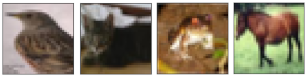

The dataset is available on [**ECAMPUS**](https://ecampus.emse.fr/course/section.php?id=7365)

The main objective is to train different deep neural network models to classify an image into one of the 4 classes.

The goal of this practical session is to experiment! Everything you need is easily available in the TENSORFLOW documentation that contains many examples.

#BONUS STRIKE 🎳

You can make additional experiences. In that case, please add bonus works at the end of your notebook in the __[BONUS]__ section.

Bonus works could bring bonus points on the global note for the practical sessions **_if and only if_** all the mandatory jobs have been done correctly.


#IMPORT LIBS

We will use TENSORFLOW, the Deep Learning platform from Google.  

TensorFlow is easy to understand and the documentation and [tutorials](https://www.tensorflow.org/tutorials) are (very) useful when learning Deep Learning.


*I already know how to develop DL models and I want to use PyTorch instead. Is it possible?*

==> *YES.* [PYTORCH](https://pytorch.org/) (from Meta) is the other big reference for DL libraries. Note that, in that case, *it's your choice* and you must be *self-sufficient* in case of development issues.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# [WARNING] About the use of COLAB and GPU

_On the top-right of the colab environment, you can chose the execution environment ("Modify the execution type") between CPU and GPU (Nvidia T4). With a free google account, there is no limitation with the CPU-only mode. With the GPU, you have a limitation that is dynamically set by Google regarding the overall load on their infrastructure. Usually, it could be 1 hour per day._

_For this practical session, you can keep the CPU mode for the MLP part. For the CNN section, you can swith to the GPU mode if you consider the processing are too slow. But, be careful and not too GPU-enthusiast._

NB: You can check the CPU info with
`!cat /proc/cpuinfo`

In [3]:
#Get CPU info
!cat /proc/cpuinfo
#Get GPU info
#!nividia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.192
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

# DOWNLOAD AND CHECK THE DATASET [3 pts]

Data must be located in a ./data directory at the same level as this notebook


In [4]:
#IF YOU USE Google COLAB, you can mount your Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Create a 'data/' directory, put the numpy files and load. With Colab case, create 'data' here:
X_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_X.npy")
Y_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_Y.npy")
print(np.shape(X_cifar4))
print(np.shape(Y_cifar4))
nb_labels=4

(24000, 32, 32, 3)
(24000,)


**[QUESTION]** Display some images from X_cifar4 with the corresponding label

_NB:_ Since the pictures are very small, use `plt.figure(figsize=(2, 2), dpi=80)` before `plt.imshow()` to display something _"watchable"_.

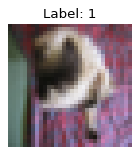

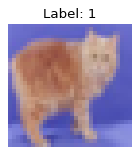

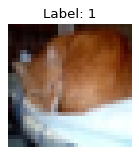

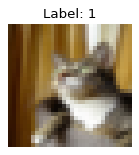

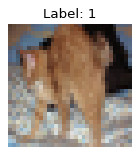

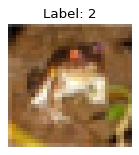

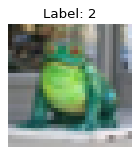

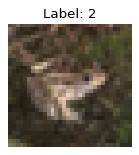

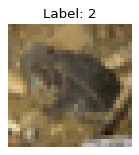

In [6]:
j = 11995  # Starting index
for i in range(j, j + 9):  # Display 9 images sequentially
    plt.figure(figsize=(2, 2), dpi=80)  # Set figure size for each image
    plt.imshow(X_cifar4[i])  # Display the image
    plt.title(f"Label: {Y_cifar4[i]}")  # Add the label as the title
    plt.axis('off')  # Remove axis for clarity
    plt.show()  # Show the image

A pixel is an UINT8 value, so in [0;255]. We will normalize data in [0,1]:

In [7]:
print("First pixel (r,g,b) of the first image:", X_cifar4[0,0,0,:])
X = X_cifar4/255.0
print("Now in [0,1] ==> ", X[0,0,0,:])


First pixel (r,g,b) of the first image: [164 206  84]
Now in [0,1] ==>  [0.64313725 0.80784314 0.32941176]


For the labels **Y**, usually, we prefer to process "one-hot encodings" i.e., a vector with '0' everywhere except for the corresponding label where you have '1'.

Example : let's say you have 4 labels and 10 training data with the original Y:
```
Y=[0,1,1,3,3,3,2,2,1,0]
shape(Y)=[10,]
```
Then the "one-hot encoding" version of Y will be:

```
Y_onehot=
[1,0,0,0;
 0,1,0,0;
 0,1,0,0;
 0,0,0,1;
 0,0,0,1;
 0,0,0,1;
 0,0,1,0;
 0,0,1,0;
 0,1,0,0;
 1,0,0,0]
shape(Y_onehot)=[10,4]
```

**[QUESTION]** Use the tensorflow method [*tf.keras.utils.to_categorical()*](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to transform your Y_cifar4 into Y and check the shape of your new Y.

In [8]:
import keras
#Your code here

Y = keras.utils.to_categorical(Y_cifar4, num_classes=4)
print(Y)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# CREATE A TRAINING/VALIDATION/TEST dataset [2 pt]

NB: This step is similar to the supervised section in TP1.

__[QUESTION]__ Use the SKLEARN method [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) in order to create:

*   a TRAIN set (X_train,Y_train) _[advice: use 70% of the whole dataset]_
*   a VALIDATION set (X_val, Y_val) _[advice: 15%]_
*   a TEST set (X_test, Y_test) _[advice: 15%]_

Print the shape of the 3 datasets.

The TRAIN and VALIDATION sets will be used at training time. The TEST set will be used, after the training, at the inference time.

NOTE that we could only use a single VALIDATION/TEST set for both the training and the inference stages.

In [9]:
#Your code here
#CREATE A TRAINING/ VALIDATION/TEST dataset
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test= train_test_split(X_cifar4, Y, train_size=0.7, random_state=42)
X_val, X_test, Y_val, Y_test= train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

# Check the sizes of the resulting datasets
print(f"Size of X_train: {X_train.shape}")
print(f"Size of Y_train: {Y_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of Y_test: {Y_test.shape}")
print(f"Size of X_val: {X_val.shape}")
print(f"Size of Y_val: {Y_val.shape}")

Size of X_train: (16800, 32, 32, 3)
Size of Y_train: (16800, 4)
Size of X_test: (3600, 32, 32, 3)
Size of Y_test: (3600, 4)
Size of X_val: (3600, 32, 32, 3)
Size of Y_val: (3600, 4)


[**QUESTION**] Why the train/val/test split is important in our case? What is the main interest of the validation data at training time?

[**ANSWER**]
CIFAR-4 is a subset of CIFAR-10 with only 4 classes and limited training examples (24,000 pictures).
Small datasets are prone to overfitting:
The validation set helps detect overfitting and fine-tune the model.
The test set ensures unbiased performance evaluation.
And splitting the data ensures the model learns effectively while maintaining a reliable measure of generalization and performance.


As for the validation data, it acts as a proxy for unseen data, enabling:
* Model Monitoring: Track the model's generalization ability during training.
* Early Stopping: Stop training if the validation performance stops improving, preventing overfitting.
* Hyperparameter Tuning: Optimize hyperparameters without contaminating the test set.

Without a validation set, you risk overfitting to the training data and cannot effectively assess generalization during training. This split ensures reliable model evaluation and performance improvement.

# MULTI-LAYER PERCEPTRON (MLP) MODEL [12 pts]

## Analyse of a MLP code [6pts]

It's time to build our first deep neural network...

Below, we provide a small code **THAT IS NOT WORKING**, because something are missing or wrong.

The model is a very simple MLP with only one hidden layer (20 neurons). So we have :   
```
x --> "input" layer ==> hidden layer ==> output layer --> ̂y   
```
Have a look at the code, and understand how it works.

In [10]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='relu')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=4
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,544 (240.41 KB)

 Trainable params: 61,544 (240.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2533 - loss: 59.8158 - val_accuracy: 0.2406 - val_loss: 1.3865
Epoch 2/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2536 - loss: 1.3863 - val_accuracy: 0.2447 - val_loss: 1.3865
Epoch 3/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2510 - loss: 1.3864 - val_accuracy: 0.2447 - val_loss: 1.3865
Epoch 4/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2525 - loss: 1.3863 - val_accuracy: 0.2447 - val_loss: 1.3864
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2503 - loss: 1.3862
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2509 - loss: 1.3863
Performance on the TRAIN set, ACCURACY= 0.2512499988079071
Performance on the TEST set, ACCURACY= 0.24944444000720978


**[QUESTION]**

   - (1) What is the activation function for the hidden layer?
   - (2) What is the most used activation function in deep learning?
   - (3) How many time an image sample will be used during the training?
   - (4) How many training iterations (i.e., params update) in total will be processed?

**[ANSWER]**

(1) The activation function for the hidden layer is relu().

(2) The the most used activation function in deep learning is relu() because ,even with its cons , it is a great way to avoid vanishing gradient and it allows a sparse activation of our network.

(3) Because this deep learning algorithm runs on 4 epochs, each image sample will be used 4 times during the training.

(4) The training dataset have 70% of image samples of our ciphar4 dataset, which means 16800 pictures. Furthermore, the MLP algorithm above is doing a mini-batch Stochastic Gradient Descent with batches of size 100, which means the training dataset have 168 batches. And this algorithm runs on 4 epochs, so in total 672(=4x 24000x0.7 / 100) training iterations will be processed.


**[QUESTION]**

   - (1) Regarding the previous questions, copy and change the code above to make it runs on **10 EPOCHS**. Comment the resulting performance of the model.
   - (2) For our MLP, why do we need this line `x = tf.keras.layers.Flatten()(inputs)` ?
   - (3) Give the calculation of the number of trainable parameters
  
   

In [18]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='relu')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=10
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,544 (240.41 KB)

 Trainable params: 61,544 (240.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2566 - loss: 76.4101 - val_accuracy: 0.2406 - val_loss: 1.3866
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2492 - loss: 1.3864 - val_accuracy: 0.2406 - val_loss: 1.3865
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2364 - loss: 1.3864 - val_accuracy: 0.2406 - val_loss: 1.3865
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2522 - loss: 1.3863 - val_accuracy: 0.2406 - val_loss: 1.3865
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2487 - loss: 1.3863 - val_accuracy: 0.2447 - val_loss: 1.3864
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2505 - loss: 1.3863 - val_accuracy: 0.2447 - val_loss: 1.3864
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2505 - loss: 1.3863 - val_accuracy: 0.2406 - val_loss: 1.3864
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2486 - loss: 1.3863 - val_accuracy: 0

**[ANSWER]** *Your answer here*

(1) Through all of our 10 epochs, we have an accuracy around 25%. However this classification task has only 4 labels equally distributed in the dataset which means that our model is a good as just choosing randomly a picture. And this accuracy of 25% is the case for both the train and the test set which means that our model is clearly **underfitting**.

(2) The line x = tf.keras.layers.Flatten()(inputs) is essential for preparing the input data for the Dense (fully connected) layers in the MLP architecture.

The input data has the shape (32, 32, 3), representing an RGB image of size 32×32 with 3 color channels. However dense Layers Require 1D Input. This is why we have a Flatten layer (x = tf.keras.layers.Flatten()(inputs)) that converts the 3D input tensor (height, width, channels) into a 1D vector.

(3) We have 2 layers, the first one with 20 neurons and the second one with 4 neurons. Which means that we have 84 (=(20+1)x4) trainable parameters if we count the biases.


It is always good to have a look on the training curves. That is the role of the "**training_history**" object that we defined in the code as the output of the **fit** method. In this object, we collect all the loss and metric values after each epoch.

You can use the following **method** to display the train/val curves (loss and accuracy):

In [13]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

**[QUESTION]** Display the training curves from your MLP model.



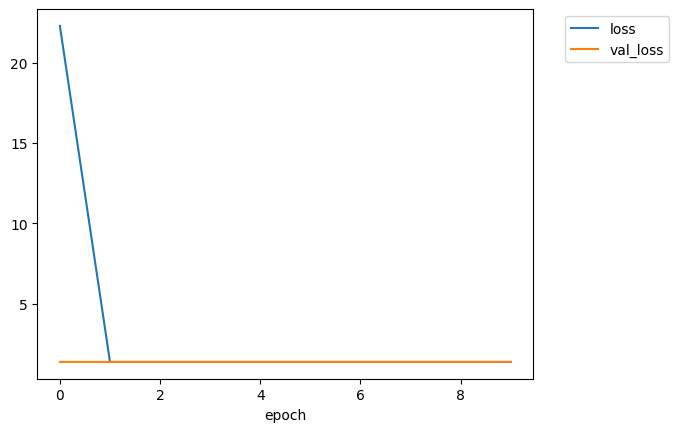

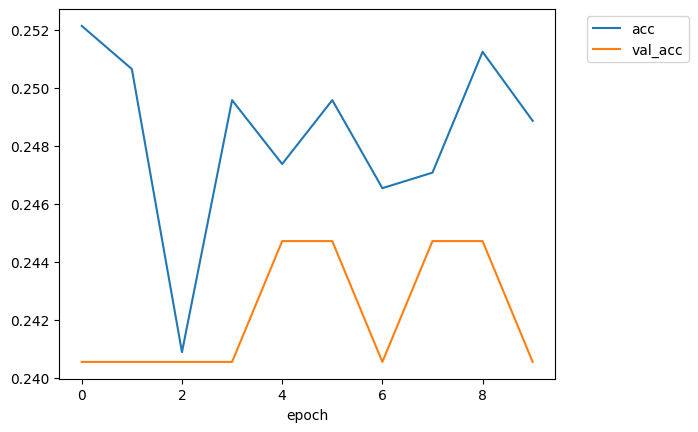

In [19]:
display_training_curves(training_history)

## Improvements and overfitting [6 pts]

**[QUESTION]** Use the previous MLP code to build your own model and try to reach a better accuracy performance (e.g., above/around 60%, both train and test)

In [20]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(1024, activation='relu')(x) #a first hidden layer with 1024 neurons
x = tf.keras.layers.Dense(768, activation='relu')(x) #a second hidden layer with 768 neurons
x = tf.keras.layers.Dense(512, activation='relu')(x) #a second hidden layer with 512 neurons
x = tf.keras.layers.Dense(256, activation='relu')(x) #a second hidden layer with 256 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x) #a second hidden layer with 128 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=22
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)



Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 768)                 │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,492,420 (17.14 MB)

 Trainable params: 4,492,420 (17.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2951 - loss: 98.4515 - val_accuracy: 0.4431 - val_loss: 1.2845
Epoch 2/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4809 - loss: 1.2057 - val_accuracy: 0.5278 - val_loss: 1.1410
Epoch 3/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5181 - loss: 1.1331 - val_accuracy: 0.5417 - val_loss: 1.0966
Epoch 4/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 1.0766 - val_accuracy: 0.5264 - val_loss: 1.1308
Epoch 5/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5730 - loss: 1.0358 - val_accuracy: 0.5669 - val_loss: 1.0396
Epoch 6/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5634 - loss: 1.0461 - val_accuracy: 0.5669 - val_loss: 1.0457
Epoch 7/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5721 - loss: 1.0150 - val_accuracy: 0.5322 - val_loss: 1.1097
Epoch 8/22
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5710 - loss: 1.0289 - val_accuracy: 0

**[QUESTION]** For illustration/educational purpose, use the code of your last model and adapt it so that your model clearly **OVERFITS**.

We need to see the overfitting issue on the training curve!

(Think about the reasons of overfitting?)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 768)                 │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,492,420 (17.14 MB)

 Trainable params: 4,492,420 (17.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2847 - loss: 119.3022 - val_accuracy: 0.3883 - val_loss: 1.4112
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4485 - loss: 1.2745 - val_accuracy: 0.5039 - val_loss: 1.1479
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5182 - loss: 1.1309 - val_accuracy: 0.4956 - val_loss: 1.1697
Epoch 4/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5228 - loss: 1.1212 - val_accuracy: 0.4847 - val_loss: 1.2066
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5377 - loss: 1.0870 - val_accuracy: 0.5297 - val_loss: 1.1188
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5569 - loss: 1.0568 - val_accuracy: 0.5647 - val_loss: 1.0615
Epoch 7/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5742 - loss: 1.0196 - val_accuracy: 0.5728 - val_loss: 1.0252
Epoch 8/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5850 - loss: 0.9861 - val_accuracy: 

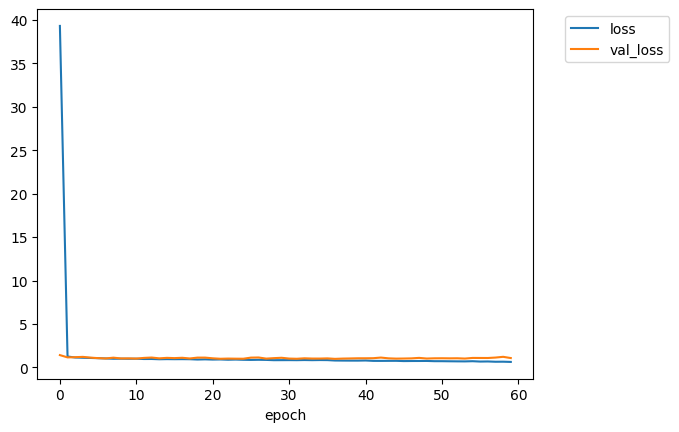

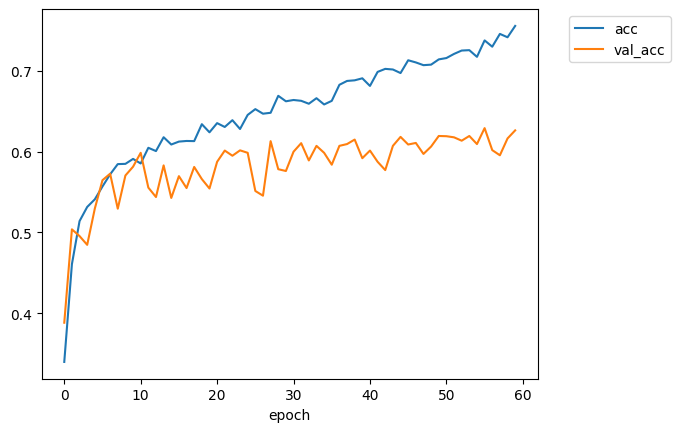

In [21]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(1024, activation='relu')(x) #a first hidden layer with 1024 neurons
x = tf.keras.layers.Dense(768, activation='relu')(x) #a second hidden layer with 768 neurons
x = tf.keras.layers.Dense(512, activation='relu')(x) #a second hidden layer with 512 neurons
x = tf.keras.layers.Dense(256, activation='relu')(x) #a second hidden layer with 256 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x) #a second hidden layer with 128 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=60
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)


**[QUESTION]** Try to find an optimal architecture without overfitting by using a regularization (or other) technique of your choice. The goal is to have a performance > 60% without overfitting after **20** epochs.


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 768)                 │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,492,420 (17.14 MB)

 Trainable params: 4,492,420 (17.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2687 - loss: 119.5292 - val_accuracy: 0.3694 - val_loss: 1.3006
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3617 - loss: 1.4203 - val_accuracy: 0.4206 - val_loss: 1.2740
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4427 - loss: 1.2367 - val_accuracy: 0.5222 - val_loss: 1.1156
Epoch 4/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5040 - loss: 1.1457 - val_accuracy: 0.5428 - val_loss: 1.0827
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5206 - loss: 1.1149 - val_accuracy: 0.5633 - val_loss: 1.0586
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5273 - loss: 1.1056 - val_accuracy: 0.5364 - val_loss: 1.0980
Epoch 7/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5273 - loss: 1.1056 - val_accuracy: 0.5597 - val_loss: 1.0470
Epoch 8/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5454 - loss: 1.0775 - val_accuracy:

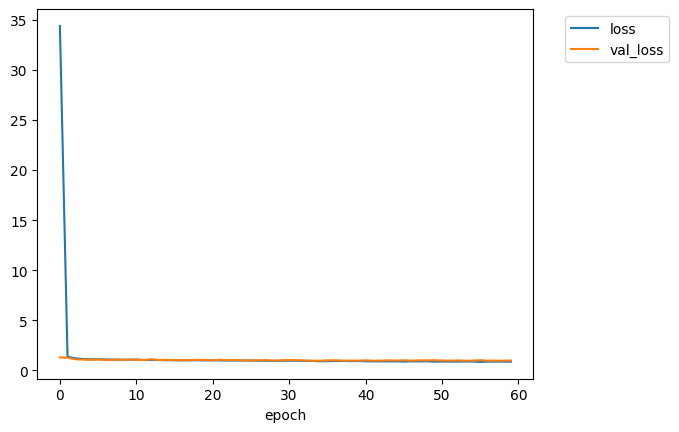

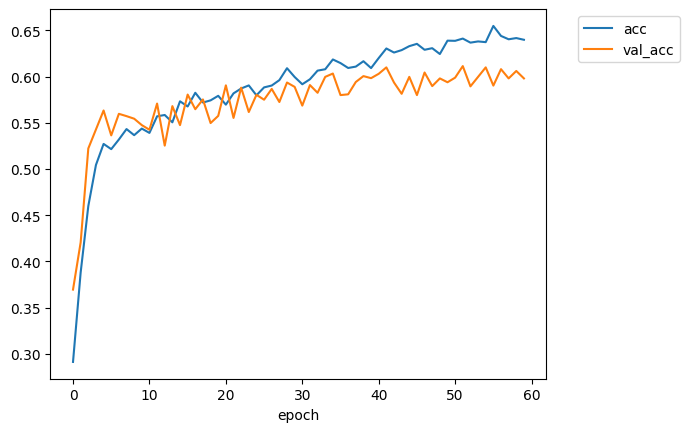

In [24]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...

#x = tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) does not work when doing it on each layer (we don't overfit but the performance fall below 60%)
#x = tf.keras.layers.BatchNormalization()(x) : ultra overfitting (training_acc : 95% and test_accuracy : 60%)
#x = tf.keras.layers.Dropout(0.1)(x)  Dropping 10% of neurons on the first layer only, allows to eliminates an important part of our problem of overfitting and even slightly improves ou model performance

x = tf.keras.layers.Dense(1024, activation='relu')(x) #a first hidden layer with 1024 neurons
x = tf.keras.layers.Dropout(0.1)(x)  #Drop 10% of neurons on the first layer
x = tf.keras.layers.Dense(768, activation='relu')(x) #a second hidden layer with 768 neurons
x = tf.keras.layers.Dense(512, activation='relu')(x) #a second hidden layer with 512 neurons
x = tf.keras.layers.Dense(256, activation='relu')(x) #a second hidden layer with 256 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x) #a second hidden layer with 128 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=60
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)
display_training_curves(training_history)



# CONVOLUTIONAL NEURAL NETWORK (CNN) [12 pts]

## Build a first architecture [6 pts]

MLPs are great but CNNs should work better for our image classification problem...

For that, we will use new layers from TF.KERAS:
   - [tf.keras.layers.Conv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) an example is:
```
l = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(l_input)
```
Here, we ask for 32 convolutional kernels of size [3,3]. By default the stride is set to '1' and the padding is 'valid'.

   - tf.keras.layers.MaxPooling2D() an example is:
```
l = tf.keras.layers.MaxPooling2D()(l_input)
```
By default the stride is set to '2' and the padding is 'valid'.



**[QUESTION]** With the default parameters of *Conv2D()*, do you expect to have the same shape for the output tensor?  

**[ANSWER]** Not at all, because of the padding='valid' (so no padding added around the input) by default, the output tensor will at least shrink by 1 in height and width.



**[QUESTION]** With the default parameters of _MaxPooling2D()_, what do you expect on the shape of the output tensor?

**[ANSWER]** With those default parameters, after a MaxPooling2D(), the output tensor will have the integer part of the half of both the height and width of the input tensor.



**[QUESTION]** Try to build a first CNN model with this architecture:

```
x --> Conv2D (32 filters) ==> MaxPooling ==> Conv2D (64 filters) ==> MaxPooling ==> Flatten ==> Dense (4) --> ̂y
```

In [25]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=7
batch_size=100
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)




Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3539 - loss: 10.3783 - val_accuracy: 0.5342 - val_loss: 1.2216
Epoch 2/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5634 - loss: 1.1031 - val_accuracy: 0.6064 - val_loss: 0.9867
Epoch 3/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6311 - loss: 0.9360 - val_accuracy: 0.6553 - val_loss: 0.8853
Epoch 4/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6785 - loss: 0.8200 - val_accuracy: 0.6583 - val_loss: 0.8801
Epoch 5/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7027 - loss: 0.7615 - val_accuracy: 0.6781 - val_loss: 0.8426
Epoch 6/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7157 - loss: 0.7308 - val_accuracy: 0.6881 - val_loss: 0.8145
Epoch 7/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7418 - loss: 0.6742 - val_accuracy: 0.6944 - val_loss: 0.8179
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.6317
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

**[QUESTION]** Display the training curves from your CNN model.


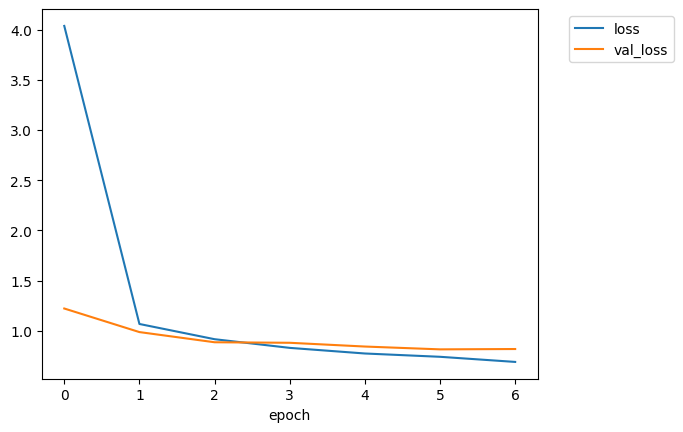

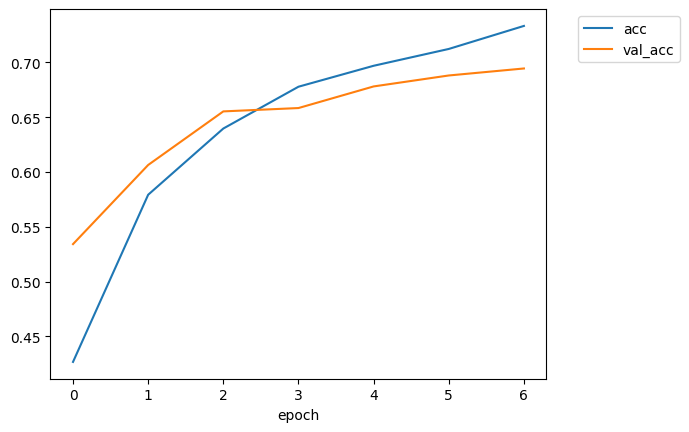

In [26]:
#Your code here
display_training_curves(training_history)


## Improvements and overfitting [6 pts]

**[QUESTION]** Use, the code of your last model and adapt it so that your model **OVERFITS**.

We need to see the overfitting issue on the training curve!

Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3548 - loss: 8.2875 - val_accuracy: 0.5075 - val_loss: 1.2061
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5358 - loss: 1.1131 - val_accuracy: 0.6061 - val_loss: 0.9752
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6153 - loss: 0.9523 - val_accuracy: 0.6100 - val_loss: 0.9490
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.8515 - val_accuracy: 0.6353 - val_loss: 0.9043
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6810 - loss: 0.8010 - val_accuracy: 0.6514 - val_loss: 0.9022
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7093 - loss: 0.7509 - val_accuracy: 0.6706 - val_loss: 0.8494
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7331 - loss: 0.6952 - val_accuracy: 0.6778 - val_loss: 0.8303
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7440 - loss: 0.6537 - val_accuracy: 0.

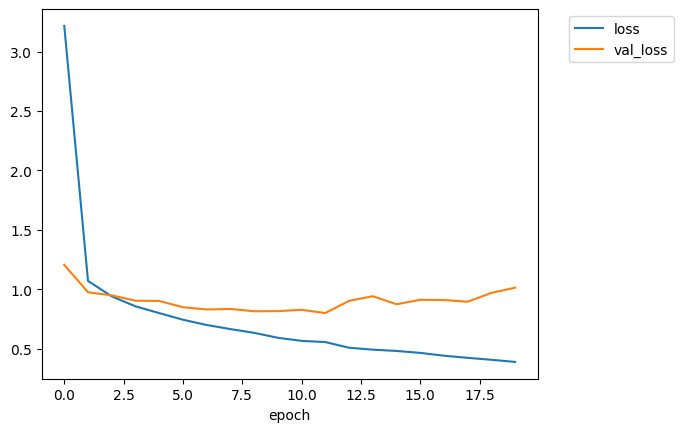

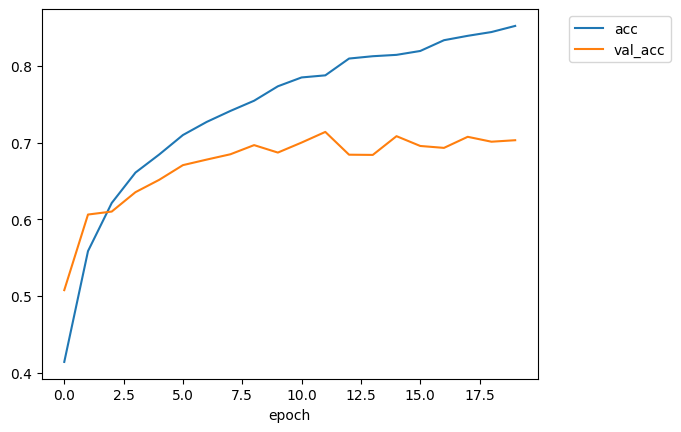

In [27]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)


**[QUESTION]** Fix your overfitting issue with a technique of your choice.


Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3367 - loss: 7.4771 - val_accuracy: 0.4758 - val_loss: 1.2342
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.4642 - loss: 1.2131 - val_accuracy: 0.5058 - val_loss: 1.1396
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.5416 - loss: 1.0850 - val_accuracy: 0.6175 - val_loss: 0.9666
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5852 - loss: 1.0016 - val_accuracy: 0.6169 - val_loss: 0.9661
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.6103 - loss: 0.9665 - val_accuracy: 0.6353 - val_loss: 0.8834
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.6282 - loss: 0.9155 - val_accuracy: 0.6744 - val_loss: 0.8637
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.6332 - loss: 0.9120 - val_accuracy: 0.6678 - val_loss: 0.8380
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.6359 - loss: 0.9035 - 

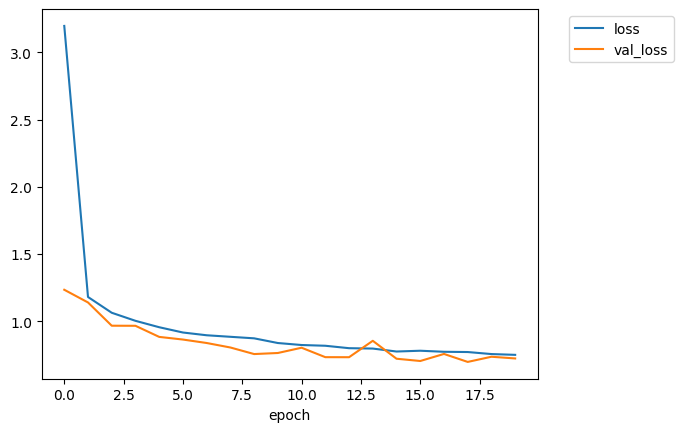

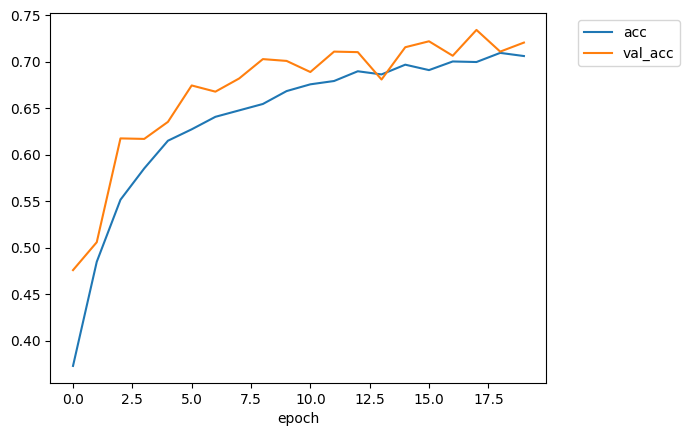

In [15]:
#Your code here

#To fight overfitting with CNN, we can use the exact same techniques of dropping out, regularization and batch normalization

#this time let's do data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#here we can see that data augmentation is by far the best method to fight overfitting, and at the same time it improves the performance of our AI. However it is true that it takesa far longer time to execute (18x times slower here)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_cnn_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)



[**QUESTION**] Regarding these experiences, compare MLP vs. CNN

[**ANSWER**] In the CIFAR-4 classification task, **CNNs consistently outperform MLPs in terms of accuracy and parameter efficiency**. A deep MLP with 4.5M parameters achieved a test accuracy of 58% after 60 epochs, with significant overfitting, as the training accuracy reached 77%. In contrast, a simple CNN architecture with only 28K parameters achieved 71% test accuracy using data augmentation and ~70% without augmentation after 20 epochs. The training-test accuracy gap for CNNs was narrower (72% vs. 71%) compared to MLPs (77% vs. 58%), indicating better generalization. Data augmentation further improved CNN performance, reducing overfitting and increasing robustness, albeit with significantly longer training times (up to 18x slower per epoch). Thus, CNNs demonstrated superior performance, higher parameter efficiency, and better generalization on CIFAR-4 compared to MLPs.










# BONUS

In [12]:
#Your code here

#To fight overfitting with CNN, we can use the exact same techniques of dropping out, regularization and batch normalization

#this time let's do data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#here we can see that data augmentation is by far the best method to fight overfitting, and at the same time it improves the performance of our AI. However it is true that it takes a far longer time to execute (18x times slower here)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=60
batch_size=100
training_history = my_cnn_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)




Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


168/168 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.3135 - loss: 7.2477 - val_accuracy: 0.4542 - val_loss: 1.3439
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.4473 - loss: 1.2496 - val_accuracy: 0.5197 - val_loss: 1.1446
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.5069 - loss: 1.1427 - val_accuracy: 0.5542 - val_loss: 1.1192
Epoch 4/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.5410 - loss: 1.0860 - val_accuracy: 0.5714 - val_loss: 1.0379
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.5670 - loss: 1.0420 - val_accuracy: 0.5833 - val_loss: 1.0318
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5789 - loss: 1.0128 - val_accuracy: 0.6103 - val_loss: 0.9751
Epoch 7/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.6042 - loss: 0.9691 - val_accuracy: 0.6678 - val_loss: 0.8670
Epoch 8/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.6244 - loss: 0.9343 - val_accurac

NameError: name 'display_training_curves' is not defined

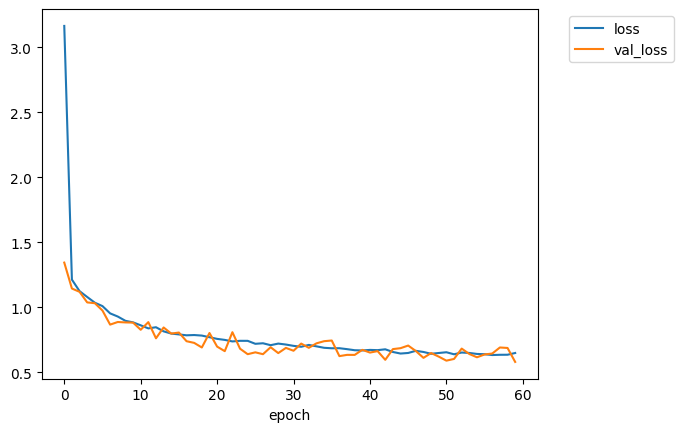

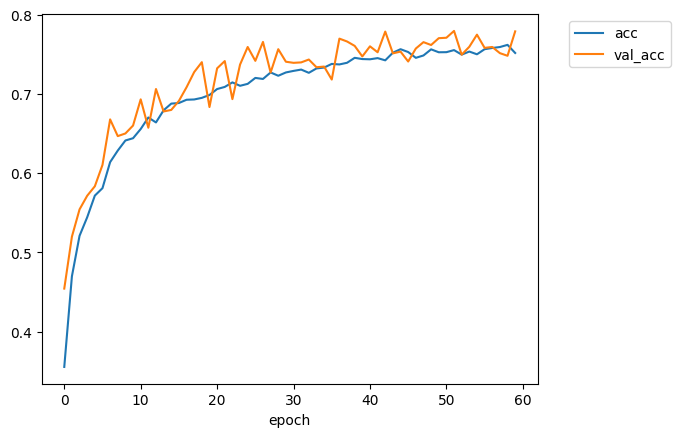

In [14]:
display_training_curves(training_history)


**[ANSWER]** This CNN achieved ~78.3% test accuracy, with data augmentation **and 60 epochs** eliminating completely the gap generalization for 60 epochs or less, albeit at 18x slower training time. This simple architecture (28,612 parameters) effectively captured spatial patterns, proving CNNs' strength in image classification by an outstanding performance of 78%. Which is the best result we get trough all of our different MLP algorithms.

Model: "my_res50_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.5658 - loss: 1.3415 - val_accuracy: 0.7167 - val_loss: 0.7305
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.6993 - loss: 0.7665 - val_accuracy: 0.7158 - val_loss: 0.7135
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7225 - loss: 0.7097 - val_accuracy: 0.7386 - val_loss: 0.6840
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.7313 - loss: 0.6856 - val_accuracy: 0.7361 - val_loss: 0.6983
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.7414 - loss: 0.6591 - val_accuracy: 0.7511 - val_loss: 0.6563
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.7456 - loss: 0.6487 - val_accuracy: 0.7256 - val_loss: 0.7020
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.7505 - loss: 0.6411 - val_accuracy: 0.7556 - val_loss: 0.6459
Epoch 8/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.7587 - loss: 0.6079 

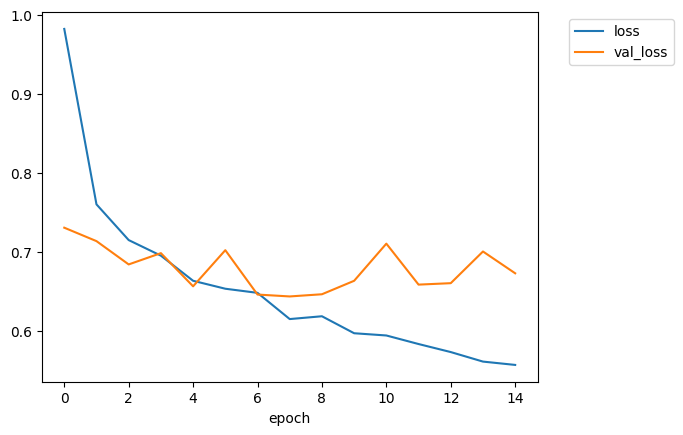

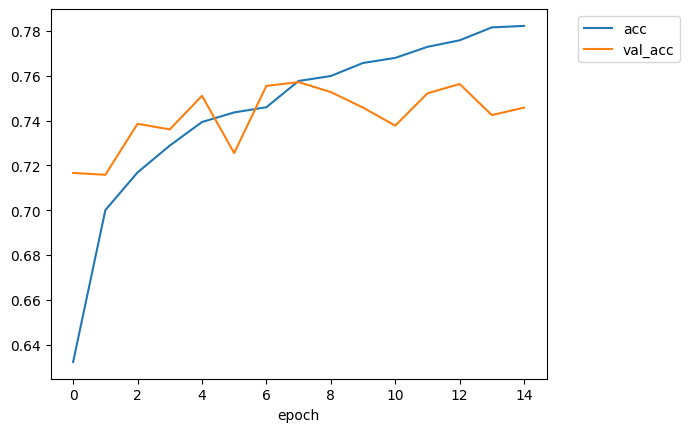

In [28]:
#Your code here

#Here we will do some transfer learning with the ResNet50 algorithm, a pre-trained deep convolutional neural network, for our CIFAR-4 dataset.

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model (optional if you only want to train the top layers)
base_model.trainable = False

# Add custom layers for CIFAR-4 classification
inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dense(128, activation='relu')(x)  # Fully connected layer

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_res50_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_res50_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_res50_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_res50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=15
batch_size=100
training_history = my_res50_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_res50_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_res50_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)



**[ANSWER]** The ResNet50 model achieved a training accuracy of 80.6% and a test accuracy of 73.1% without data augmentation, highlighting its strong feature extraction capabilities due to pre-training on ImageNet. However, the 7.5% accuracy gap between training and test sets indicates some overfitting. The model's performance reflects the power of transfer learning, as the base ResNet50 layers effectively extracted features, requiring minimal fine-tuning of added dense layers. Incorporating data augmentation could further improve generalization and close the performance gap. Despite limited epochs and a frozen base model, ResNet50 efficiently adapted to the CIFAR-4 dataset, showing its robustness for smaller, specialized datasets.

Model: "my_res50_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.5732 - loss: 1.2195 - val_accuracy: 0.7189 - val_loss: 0.7440
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.6973 - loss: 0.7639 - val_accuracy: 0.7175 - val_loss: 0.7238
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.7221 - loss: 0.7096 - val_accuracy: 0.7319 - val_loss: 0.6944
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.7295 - loss: 0.6854 - val_accuracy: 0.7472 - val_loss: 0.6660
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.7350 - loss: 0.6696 - val_accuracy: 0.7556 - val_loss: 0.6558
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.7456 - loss: 0.6493 - val_accuracy: 0.7467 - val_loss: 0.6676
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.7500 - loss: 0.6295 - val_accuracy: 0.7436 - val_loss: 0.6690
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7579 - loss: 0.6115 

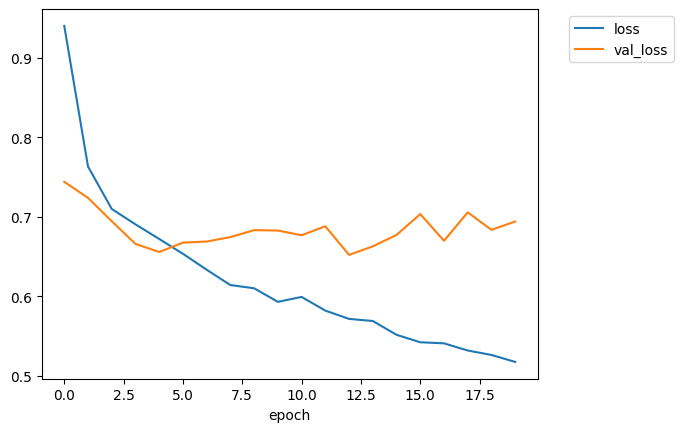

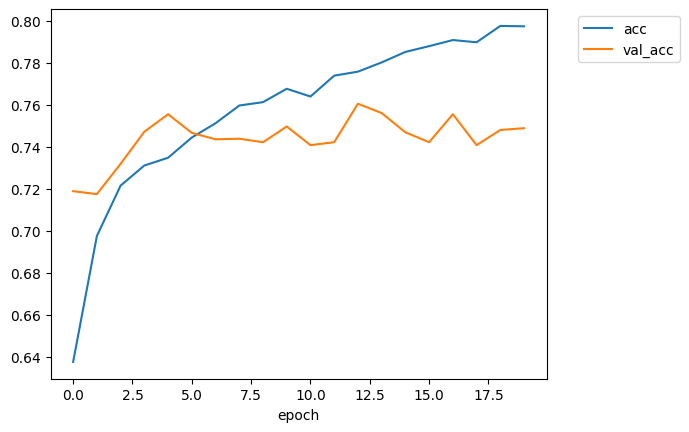

In [32]:
#Your code here

#Here we will do some transfer learning with the ResNet50 algorithm, a pre-trained deep convolutional neural network, for our CIFAR-4 dataset.

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model (optional if you only want to train the top layers)
base_model.trainable = False

# Add custom layers for CIFAR-4 classification
inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dense(128, activation='relu')(x)  # Fully connected layer

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_res50_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_res50_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_res50_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_res50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_res50_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_res50_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_res50_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)



**[ANSWER]** The ResNet50 model with data augmentation shows promising training performance (accuracy: 82.1%) but a notable drop in test accuracy (74.5%), indicating some degree of overfitting despite augmentation. The steady improvement in training accuracy alongside fluctuating validation accuracy and increasing validation loss suggests the model is struggling to generalize effectively. While the architecture and augmentation strategy are solid, the gap between training and test performance highlights potential improvements, such as fine-tuning deeper layers of ResNet50, adding regularization like dropout or L2 penalties, and employing learning rate scheduling to enhance convergence and generalization.